In [25]:
#!pip install pypdf
#!pip install bertopic


In [26]:
from langchain_community.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

import os
from pathlib import Path
import pandas as pd
import nltk
from nltk.corpus import words
import re
from html import unescape

import pycountry
from sklearn.feature_extraction import text 


from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration, OpenAI
import openai

import numpy as np

# Download the words dataset from nltk
nltk.download('words')
nltk.download('punkt')



[nltk_data] Downloading package words to
[nltk_data]     /Users/eryclisrodrigues/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eryclisrodrigues/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Manipulating data extracted by OCR

1. Load the data extracted
2. Clean the data - fixing OCR errors
3. Split it up by using LangChain

#### 1. Load the data extracted

In [27]:
# load data (OCR'd text)

df_ocr = pd.read_csv(
    r"/Users/eryclisrodrigues/Documents/Eryclis - docs/Research/Projects/AI Governance - Topic Modeling/Data/Intermediate Data/Intermediate Data.csv",
   )

In [28]:
df_ocr

Document  \
0   [Switzerland] Digital Switzerland Strategy 202...   
1   [Pakistan] National AI Policy Consultation Dra...   
2   [Saudi Arabia 2020] - National Strategy for Da...   
3                          [Malaysia] AI Road Map.pdf   
4                [Hong Kong] Ethical_AI_Framework.pdf   
5          Rawanda_Artificial_Intelligence_Policy.pdf   
6   AI for Africa Artificial Intelligence for Afri...   
7                 [Spain] National-Strategy-on-AI.pdf   
8                             Tunisia_Startup Act.pdf   
9   [Korea] National Strategy for Artificial Intel...   
10  [Cambodia] AI Landscape in Cambodia - Current ...   
11      South Africa_Fourth Industrial Revolution.pdf   
12            [Singapore] AI Governance Framework.pdf   
13                  Australia_AI_Action_Plan_2021.pdf   
14                 [Germany] National AI Strategy.pdf   
15                           [Japan] AI Principle.pdf   
16  Italy_Artificial_Intelligence_Strategic_Progra...   
17  [Czech] National Artificial Intelligence Strat...   
18                 [Ireland] National-ai-strategy.pdf   
19  Lithuania_Artificial_Intelligence_Strategy_201...   
20  Poland_Policy_for_Artificial_Intelligence_Deve...   
21                                   Romania-2019.pdf   
22  [United Arab Emirates] - National Strategy for...   
23  [China AI Regulation for 2023] Measures for th...   
24  [Bulgaria} CONCEPT FOR THE DEVELOPMENT OF ARTI...   
25  [Vietnam] - National Strategy On R&D and Appli...   
26                            Luxemburg - AI_EN_0.pdf   
27      [Philipines] National AI Strategy Roadmap.pdf   
28  Norway_National_Strategy_for_Artificial_Intell...   
29         [India 2021] - Responsible AI Document.pdf   
30                   [Qatar] National AI Strategy.pdf   
31  Nigeria Policy-National_Digital_Economy_Policy...   
32  Sweden_National_Approach_to_Artificial_Intelli...   
33                     Egypt National AI Strategy.pdf   
34  [UK] National AI Strategy - HTML version - GOV...   
35  [USA] National-Artificial-Intelligence-Researc...   
36  Serbia_Strategy_for_Development_of_Artificial_...   
37                 [Denmark] National AI strategy.pdf   
38                          Mauritius AI Strategy.pdf   
39  Netherlands_Strategic_Action_Plan_for_Artifici...   
40            Portugal_AI_Portugal_2030_2019-2030.pdf   

                                                 Text  
0   \n\nPage 1:\n\nSchweizerische Eidgenossenschaf...  
1   \n\nPage 1:\n\nMinistry of Information Technol...  
2   \n\nPage 1:\n\nNSDAI aibgll auuljiwJl yclikJl ...  
3   \n\nPage 1:\n\nKEMENTERIAN SAINS  TEKNOLOGI DA...  
4   \n\nPage 1:\n\nOffice of the Government Chief ...  
5   \n\nPage 1:\n\n'Lmunn Fimu CA Republic of Rwan...  
6   \n\nPage 1:\n\nAI FOR AFRICA: ARTIFICIAL INTEL...  
7   \n\nPage 1:\n\nenia nationAL ARTIficiaL Inteli...  
8   \n\nPage 1:\n\nQ The Tunisian Startup Act CREA...  
9   \n\nPage 1:\n\nGPRN 11-1721000-000393-01 A} Na...  
10  \n\nPage 1:\n\nKINGDOM OF CAMBODIA NATION RELI...  
11  \n\nPage 1:\n\nNo_ 42388 GOVERNMENT GAZETTE, 9...  
12  \n\nPage 1:\n\nL 0 MODEL ARTIFICIAL INTELLIGEN...  
13  \n\nPage 1:\n\n3 Australian Government AUSTRAL...  
14  \n\nPage 1:\n\nThe Artificial Intelligence Str...  
15  \n\nPage 1:\n\nSocial Principles of Human-Cent...  
16  \n\nPage 1:\n\nStrategic Programme on Artifici...  
17  \n\nPage 1:\n\nCzech Republic MINISTRY OF INDU...  
18  \n\nPage 1:\n\nRialtas na hEireann Government ...  
19  \n\nPage 1:\n\nCreate MINISTRY 0F THE ECONOMY ...  
20  \n\nPage 1:\n\nAppendix to the Resolution no. ...  
21  \n\nPage 1:\n\nRomania in the era of Artificia...  
22  \n\nPage 1:\n\nGelibeYlelSiw gibsla bisti NATI...  
23  \n\nPage 1:\n\nMeasures for the Management of ...  
24  \n\nPage 1:\n\nREPUBLIC OF BULGARIA MINISTRY O...  
25  \n\nPage 1:\n\n23. 11.9. 28 4.38 National Stra...  
26  \n\nPage 1:\n\nArtificial Intelligence: a stra...  
27  \n\nPage 1:\n\nNATIONAL AI STRATEGY ROADMAP FO...  
28  \n\nPage 1:\n\nNorwegi

#### 2. Clean the data

In [29]:
import re
from html import unescape
from nltk.corpus import words

# Load the list of English words
english_words = set(words.words())

def clean_text(text):
    # 1. Replace \n with space
    #text = text.replace('\n', ' ')
    
    # 2. Remove extra spaces
    #text = re.sub(r'\s+', ' ', text)
    
    # 2. Convert text to lowercase
    text = text.lower()
    
    # 3. Remove leading and trailing spaces
    text = text.strip()
    
    # 4. Remove URLs
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 5. Decode HTML entities
    text = unescape(text)
    
    # 6. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 7. Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # 8. Remove page references (e.g., Page 1:)
    text = re.sub(r'Page \d+:', '', text, flags=re.IGNORECASE)
    
    # 9. Remove isolated digits (keeping punctuation)
    text = re.sub(r'\b\d+\b', '', text)
    
    # 10. Remove mentions (e.g., @username)
    text = re.sub(r'@\S+', '', text)
    
    # 11. Replace '&' with 'and'
    text = text.replace('&', 'and')
    
    # 12. Remove special characters, keeping basic punctuation
    #text = re.sub(r'[^a-zA-Z0-9.,!?\'\s]', '', text)
    
    # 13. Remove words not in the English vocabulary
    #words_list = text.split()
    #cleaned_words = [word for word in words_list if word.lower() in english_words or re.match(r'[.,!?\'-]', word)]
    #text = ' '.join(cleaned_words)
    
    return text
    


In [30]:
df_ocr_copy = df_ocr.copy()

In [31]:
df_ocr_copy['Text'] = df_ocr_copy["Text"].apply(clean_text)

In [32]:
df_ocr_copy

Document  \
0   [Switzerland] Digital Switzerland Strategy 202...   
1   [Pakistan] National AI Policy Consultation Dra...   
2   [Saudi Arabia 2020] - National Strategy for Da...   
3                          [Malaysia] AI Road Map.pdf   
4                [Hong Kong] Ethical_AI_Framework.pdf   
5          Rawanda_Artificial_Intelligence_Policy.pdf   
6   AI for Africa Artificial Intelligence for Afri...   
7                 [Spain] National-Strategy-on-AI.pdf   
8                             Tunisia_Startup Act.pdf   
9   [Korea] National Strategy for Artificial Intel...   
10  [Cambodia] AI Landscape in Cambodia - Current ...   
11      South Africa_Fourth Industrial Revolution.pdf   
12            [Singapore] AI Governance Framework.pdf   
13                  Australia_AI_Action_Plan_2021.pdf   
14                 [Germany] National AI Strategy.pdf   
15                           [Japan] AI Principle.pdf   
16  Italy_Artificial_Intelligence_Strategic_Progra...   
17  [Czech] National Artificial Intelligence Strat...   
18                 [Ireland] National-ai-strategy.pdf   
19  Lithuania_Artificial_Intelligence_Strategy_201...   
20  Poland_Policy_for_Artificial_Intelligence_Deve...   
21                                   Romania-2019.pdf   
22  [United Arab Emirates] - National Strategy for...   
23  [China AI Regulation for 2023] Measures for th...   
24  [Bulgaria} CONCEPT FOR THE DEVELOPMENT OF ARTI...   
25  [Vietnam] - National Strategy On R&D and Appli...   
26                            Luxemburg - AI_EN_0.pdf   
27      [Philipines] National AI Strategy Roadmap.pdf   
28  Norway_National_Strategy_for_Artificial_Intell...   
29         [India 2021] - Responsible AI Document.pdf   
30                   [Qatar] National AI Strategy.pdf   
31  Nigeria Policy-National_Digital_Economy_Policy...   
32  Sweden_National_Approach_to_Artificial_Intelli...   
33                     Egypt National AI Strategy.pdf   
34  [UK] National AI Strategy - HTML version - GOV...   
35  [USA] National-Artificial-Intelligence-Researc...   
36  Serbia_Strategy_for_Development_of_Artificial_...   
37                 [Denmark] National AI strategy.pdf   
38                          Mauritius AI Strategy.pdf   
39  Netherlands_Strategic_Action_Plan_for_Artifici...   
40            Portugal_AI_Portugal_2030_2019-2030.pdf   

                                                 Text  
0   \n\nschweizerische eidgenossenschaft bundeskan...  
1   \n\nministry of information technology and tel...  
2   \n\nnsdai aibgll auuljiwjl yclikjl -gsilg =lil...  
3   \n\nkementerian sains  teknologi dan inovasi m...  
4   \n\noffice of the government chief information...  
5   \n\n'lmunn fimu ca republic of rwanda ministry...  
6   \n\nai for africa: artificial intelligence for...  
7   \n\nenia national artificial inteligence estra...  
8   \n\nq the tunisian startup act creating a lega...  
9   \n\ngprn --- a} national strategy for artifici...  
10  \n\nkingdom of cambodia nation religion king l...  
11  \n\nno_  government gazette,  april  general n...  
12  \n\nl  model artificial intelligence governanc...  
13  \n\n australian government australia's ai acti...  
14  \n\nthe artificial intelligence strategy of fe...  
15  \n\nsocial principles of human-centric ai tabl...  
16  \n\nstrategic programme on artificial intellig...  
17  \n\nczech republic ministry of industry and tr...  
18  \n\nrialtas na heireann government of ireland ...  
19  \n\ncreate ministry 0f the economy lithuania a...  
20  \n\nappendix to the resolution no.  of the cou...  
21  \n\nromania in the era of artificial intellige...  
22  \n\ngelibeylelsiw gibsla bisti nationalprogram...  
23  \n\nmeasures for the management of generative ...  
24  \n\nrepublic of bulgaria ministry of transport...  
25  \n\n. ..  . national strategy on randd and app...  
26  \n\nartificial intelligence: a strategic visio...  
27  \n\nnational ai strategy roadmap for the phili...  
28  \n\nnorwegian ministry

In [33]:
# Let's create a csv file to visualize better the document and make comparisons

df_ocr_copy.to_csv('/Users/eryclisrodrigues/Documents/Eryclis - docs/Research/Projects/AI Governance - Topic Modeling/Data/Intermediate Data/second_cleaned_data.csv')

In [34]:
df_ocr_copy['Text'][10][10:40]

'of cambodia nation religion ki'

#### 3. Text Splitter - Langchain

- First by using Recursive Character Text Splitter
- Other option that might be experimented after is called "Semantic Chuncking"

In [35]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len,
    is_separator_regex=False,
)

In [36]:
# First of all, we need to convert our variable 'docs' into a Langchain Document

documents = [Document(page_content=text) for text in df_ocr_copy['Text']]

In [37]:
split_texts = []
for doc in documents:
    split_texts.extend(splitter.split_text(doc.page_content))

In [38]:
len(split_texts)

5445

#### Costumized Data Cleaning
- First, we have to replace wrong words extracted by OCR;
- Since most documents often reflect the name of its own country in differente ways, we will try to eliminate the those names.

In [39]:
# dict of string replacements for texts, made by visually inspecting the possibly wrong column

replacements_dict = {'al':'ai','reaiizing':'realizing','anaiytics':'analytics','technologicai':'technological','locai':'local','nationai':'national','vaiue':'value','artificiai':'artificial','steei': 'steel', 'physioiogicai': 'physiological', 'empiricai': 'empirical', 'stiii': 'still', 'schooi': 'school', 'integrai': 'integral', 'scandai': 'scandal', 'jurisdictionai': 'jurisdictional', 'proportionai': 'proportional', 'accidentai': 'accidental', 'entai': 'ental', 'inteiiectuai': 'intellectual', 'materiai': 'material', 'upheavai': 'upheaval', 'causai': 'causal', 'bai': 'bal', 'originai': 'original', 'arrivai': 'arrival', 'provisionai': 'provisional', 'ai': 'al', 'voi': 'vol', 'factuai': 'factual', 'foundationai': 'foundational', 'civiiizationai': 'civilizational', 'infiuentiai': 'influential', 'apparei': 'apparel', 'incrementai': 'incremental', 'steai': 'steal', 'signai': 'signal', 'nontechnicai': 'nontechnical', 'proposai': 'proposal', 'poiiticai': 'political', 'journai': 'journal', 'quintessentiai': 'quintessential', 'frictionai': 'frictional', 'agricuiturai': 'agricultural', 'governmentai': 'governmental', 'speii': 'spell', 'ievei': 'level', 'haui': 'haul', 'entrepreneuriai': 'entrepreneurial', 'rurai': 'rural', 'presurgicai': 'presurgical', 'existentiai': 'existential', 'iiiegai': 'illegal', 'triai': 'trial', 'uniawfui': 'unlawful', 'aii': 'ail', 'fiii': 'fill', 'operationai': 'operational', 'iogisticai': 'logistical', 'inaugurai': 'inaugural', 'focai': 'focal', 'physicai': 'physical', 'criminai': 'criminal', 'penai': 'penal', 'generai': 'general', 'coiossai': 'colossal', 'ciericai': 'clerical', 'shaii': 'shall', 'universai': 'universal', 'ideai': 'ideal', 'personnei': 'personnel', 'professionai': 'professional', 'archivai': 'archival', 'ministeriai': 'ministerial', 'terminai': 'terminal', 'traditionai': 'traditional', 'deai': 'deal', 'manuai': 'manual', 'fundamentai': 'fundamental', 'sentimentai': 'sentimental', 'toii': 'toll', 'controversiai': 'controversial', 'credentiai': 'credential', 'nonpersonai': 'nonpersonal', 'unidirectionai': 'unidirectional', 'triiaterai': 'trilateral', 'soii': 'soil', 'puii': 'pull', 'cuiturai': 'cultural', 'ciinicai': 'clinical', 'iii': 'ill', 'ceii': 'cell', 'mathematicai': 'mathematical', 'pooi': 'pool', 'horizontai': 'horizontal', 'fooi': 'fool', 'constitutionai': 'constitutional', 'retrievai': 'retrieval', 'minimai': 'minimal', 'procedurai': 'procedural', 'odei': 'odel', 'instrumentai': 'instrumental', 'generationai': 'generational', 'potentiai': 'potential', 'urai': 'ural', 'interpersonai': 'interpersonal', 'usefui': 'useful', 'digitai': 'digital', 'tacticai': 'tactical', 'structurai': 'structural', 'annuai': 'annual', 'muitinationai': 'multinational', 'umbrei': 'umbrel', 'maii': 'mall', 'panei': 'panel', 'mii': 'mil', 'attentionai': 'attentional', 'footfaii': 'footfall', 'impartiai': 'impartial', 'individuai': 'individual', 'representationai': 'representational', 'perpetuai': 'perpetual', 'naturai': 'natural', 'unequai': 'unequal', 'anai': 'anal', 'institutionai': 'institutional', 'speciai': 'special', 'nuii': 'null', 'unveii': 'unveil', 'retaii': 'retail', 'perceptuai': 'perceptual', 'impracticai': 'impractical', 'iiberai': 'liberal', 'ciassicai': 'classical', 'handfui': 'handful', 'occupationai': 'occupational', 'faii': 'fall', 'statisticai': 'statistical', 'iobai': 'lobal', 'fossii': 'fossil', 'travei': 'travel', 'correctionai': 'correctional', 'behaviorai': 'behavioral', 'typicai': 'typical', 'diagonai': 'diagonal', 'faciai': 'facial', 'phiiosophicai': 'philosophical', 'survivai': 'survival', 'differentiai': 'differential', 'rei': 'rel', 'technicai': 'technical', 'muitimodai': 'multimodal', 'deveiopmentai': 'developmental', 'withdrawai': 'withdrawal', 'radicai': 'radical', 'portai': 'portal', 'tooi': 'tool', 'maritai': 'marital', 'initiai': 'initial', 'refusai': 'refusal', 'intentionai': 'intentional', 'recaii': 'recall', 'meteoroiogicai': 'meteorological', 'experientiai': 'experiential', 'essentiai': 'essential', 'gratefui': 'grateful', 'successfui': 'successful', 'biiaterai': 'bilateral', 'finai': 'final', 'festivai': 'festival', 'organizationai': 'organizational', 'conventionai': 'conventional', 'formai': 'formal', 'detrimentai': 'detrimental', 'conversationai': 'conversational', 'funnei': 'funnel', 'municipai': 'municipal', 'rationai': 'rational', 'mutuai': 'mutual', 'fuifiii': 'fulfill', 'iogicai': 'logical', 'fuei': 'fuel', 'stressfui': 'stressful', 'councii': 'council', 'animai': 'animal', 'externai': 'external', 'severai': 'several', 'reai': 'real', 'virai': 'viral', 'vitai': 'vital', 'experimentai': 'experimental', 'geographicai': 'geographical', 'regionai': 'regional', 'preferentiai': 'preferential', 'fiscai': 'fiscal', 'seai': 'seal', 'oii': 'oil', 'irrationai': 'irrational', 'verbai': 'verbal', 'historicai': 'historical', 'centenniai': 'centennial', 'heipfui': 'helpful', 'beneficiai': 'beneficial', 'mindfui': 'mindful', 'functionai': 'functional', 'sexuai': 'sexual', 'wheei': 'wheel', 'continuai': 'continual', 'normai': 'normal', 'powerfui': 'powerful', 'seii': 'sell', 'unusuai': 'unusual', 'rivai': 'rival', 'excei': 'excel', 'iegai': 'legal', 'interministeriai': 'interministerial', 'detaii': 'detail', 'riai': 'rial', 'provinciai': 'provincial', 'internai': 'internal', 'presidentiai': 'presidential', 'modei': 'model', 'contractuai': 'contractual', 'raii': 'rail', 'cooi': 'cool', 'commerciai': 'commercial', 'faithfui': 'faithful', 'optimai': 'optimal', 'graphicai': 'graphical', 'surgicai': 'surgical', 'avaii': 'avail', 'criticai': 'critical', 'choiesteroi': 'cholesterol', 'enroi': 'enrol', 'deraii': 'derail', 'equai': 'equal', 'nii': 'nil', 'usuai': 'usual', 'confidentiai': 'confidential', 'opticai': 'optical', 'principai': 'principal', 'caii': 'call', 'cai': 'cal', 'vocationai': 'vocational', 'harmfui': 'harmful', 'biii': 'bill', 'internationai': 'international', 'judiciai': 'judicial', 'paraiiei': 'parallel', 'brazii': 'brazil', 'practicai': 'practical', 'approvai': 'approval', 'personai': 'personal', 'virtuai': 'virtual', 'traii': 'trail', 'appeai': 'appeal', 'aeriai': 'aerial', 'novei': 'novel', 'federai': 'federal', 'fuii': 'full', 'technoiogicai': 'technological', 'ternai': 'ternal', 'overaii': 'overall', 'empanei': 'empanel', 'meaningfui': 'meaningful', 'channei': 'channel', 'dactyi': 'dactyl', 'muitidirectionai': 'multidirectional', 'cruciai': 'crucial', 'medicai': 'medical', 'skiii': 'skill', 'disposai': 'disposal', 'mentai': 'mental', 'eiectricai': 'electrical', 'controi': 'control', 'graii': 'grail', 'unethicai': 'unethical', 'protocoi': 'protocol', 'artificiai': 'artificial', 'instiii': 'instill', 'royai': 'royal', 'carefui': 'careful', 'doctorai': 'doctoral', 'verticai': 'vertical', 'giobai': 'global', 'thermai': 'thermal', 'iabei': 'label', 'reveai': 'reveal', 'promotionai': 'promotional', 'prejudiciai': 'prejudicial', 'snowbaii': 'snowball', 'industriai': 'industrial', 'feei': 'feel', 'roii': 'roll', 'additionai': 'additional', 'environmentai': 'environmental', 'substantiai': 'substantial', 'counsei': 'counsel', 'sociai': 'social', 'miii': 'mill', 'ethicai': 'ethical', 'officiai': 'official', 'goai': 'goal', 'removai': 'removal', 'raciai': 'racial', 'teii': 'tell', 'acriticai': 'acritical', 'societai': 'societal', 'driii': 'drill', 'coi': 'col', 'graduai': 'gradual', 'pivotai': 'pivotal', 'optionai': 'optional', 'educationai': 'educational', 'consequentiai': 'consequential', 'centrai': 'central', 'intergovernmentai': 'intergovernmental', 'totai': 'total', 'kiii': 'kill', 'asweii': 'aswell', 'sectorai': 'sectoral', 'contextuai': 'contextual', 'medievai': 'medieval', 'anaiyticai': 'analytical', 'sectoriai': 'sectorial', 'emotionai': 'emotional', 'departmentai': 'departmental', 'exponentiai': 'exponential', 'remediai': 'remedial', 'appraisai': 'appraisal', 'tiii': 'till', 'mai': 'mal', 'muitiiaterai': 'multilateral', 'nationai': 'national', 'duai': 'dual', 'bioiogicai': 'biological', 'intervai': 'interval', 'editoriai': 'editorial', 'computationai': 'computational', 'uniiaterai': 'unilateral', 'visuai': 'visual', 'financiai': 'financial', 'neutrai': 'neutral', 'aiphabeticai': 'alphabetical', 'capitai': 'capital', 'ontoiogicai': 'ontological', 'smaii': 'small', 'interactionai': 'interactional', 'cari': 'carl', 'biannuai': 'biannual', 'mechanicai': 'mechanical', 'fatai': 'fatal', 'prevaii': 'prevail', 'morai': 'moral', 'compei': 'compel', 'unintentionai': 'unintentional', 'iawfui': 'lawful', 'iocai': 'local', 'weii': 'well', 'redressai': 'redressal', 'entaii': 'entail', 'hospitai': 'hospital', 'pharmaceuticai': 'pharmaceutical', 'neurai': 'neural', 'partiai': 'partial', 'chemicai': 'chemical', 'actuai': 'actual', 'reiationai': 'relational', 'psychoiogicai': 'psychological', 'textuai': 'textual', 'civii': 'civil'    
}

In [40]:
len(split_texts)

5445

In [41]:
def apply_replacements_to_chunks(chunks, replacements):
    
    corrected_chunks = []
    for chunk in chunks:
        # Dividir o chunk em palavras
        words = chunk.split()
        
        # Aplicar substituições nas palavras
        corrected_words = [replacements.get(word, word) for word in words]
        
        # Transformar palavras corrigidas de volta em uma string
        corrected_chunk_str = ' '.join(corrected_words)
        
        # Adicionar o chunk corrigido à lista
        corrected_chunks.append(corrected_chunk_str)
    
    return corrected_chunks


In [42]:
cleaned_texts = apply_replacements_to_chunks(split_texts, replacements_dict)


In [43]:
len(cleaned_texts)

5445

In [44]:
cleaned_texts[987]

'radiologists with priority list of patients based on their conditions_ .. energy despite steady economic in africa, widening electricity access in sub-saharan countries remains problematic. wind , solar , geothermal , and hydro energy are explored as the main potential solutions to meet fast-growing energy testing drug using deep deep growth'

In [45]:

# Getting a list of all countries
countries = list(pycountry.countries)

# Create separate list to names and oficial names
country_names = [(country.name).lower() for country in countries]
official_names = [country.official_name.lower() if hasattr(country, 'official_name') else '' for country in countries]

all_countries = country_names + official_names

In [46]:
type(all_countries)

list

In [47]:
# List of all derived contries names

derived_countries_names = [
    'abkhaz', 'abkhazian', 'abkhazians',
    'afghan', 'afghans',
    'åland island', 'ålanders',
    'albanian', 'albanians',
    'algerian', 'algerians',
    'american samoan', 'american samoans',
    'andorran', 'andorrans',
    'angolan', 'angolans',
    'anguillan', 'anguillans',
    'antarctic', 'antarctic residents', 'antarcticans',
    'antiguan', 'barbudan', 'antiguans', 'barbudans',
    'argentine', 'argentinian', 'argentines', 'argentinians',
    'armenian', 'armenians',
    'aruban', 'arubans',
    'australian', 'australians',
    'austrian', 'austrians',
    'azerbaijani', 'azeri', 'azerbaijanis', 'azeris',
    'bahamian', 'bahamians',
    'bahraini', 'bahrainis',
    'bangladeshi', 'bangladeshis',
    'barbadian', 'barbadians',
    'belarusian', 'belarusians',
    'belgian', 'belgians',
    'belizean', 'belizeans',
    'beninese', 'beninois',
    'bermudian', 'bermudan', 'bermudians', 'bermudans',
    'bhutanese',
    'bolivian', 'bolivians',
    'bonairean', 'bonaire dutch',
    'bosnian', 'herzegovinian', 'bosnians', 'herzegovinians',
    'botswana', 'batswana', 'motswana',
    'bouvet islanders',
    'brazilian', 'brazilians',
    'biot', 'british',
    'bruneian', 'bruneians',
    'bulgarian', 'bulgarians',
    'burkinabé', 'burkinabè',
    'burundian', 'burundians', 'barundi',
    'cabo verdean', 'cabo verdeans',
    'cambodian', 'cambodians',
    'cameroonian', 'cameroonians',
    'canadian', 'canadians',
    'caymanian', 'caymanians',
    'central african', 'central africans',
    'chadian', 'chadians',
    'chilean', 'chileans',
    'chinese',
    'christmas islanders',
    'cocos islanders',
    'colombian', 'colombians',
    'comoran', 'comorian', 'comorans', 'comorians',
    'congolese',
    'cook islanders',
    'costa rican', 'costa ricans',
    'croatian', 'croatians', 'croats',
    'cuban', 'cubans',
    'curaçaoan', 'curaçaoans',
    'cypriot', 'cypriots',
    'czech', 'czechs',
    'danish', 'danes',
    'djiboutian', 'djiboutians',
    'dominican', 'dominicans',
    'timorese',
    'ecuadorian', 'ecuadorians',
    'egyptian', 'egyptians',
    'salvadoran', 'salvadorans', 'salvadorians', 'salvadoreans',
    'english', 'englishmen', 'englishwomen',
    'equatorial guinean', 'equatoguinean', 'equatorial guineans', 'equatoguineans',
    'eritrean', 'eritreans',
    'estonian', 'estonians',
    'swazi', 'swati', 'swazis',
    'ethiopian', 'ethiopians', 'habesha',
    'european', 'europeans',
    'falkland islanders',
    'faroese',
    'fijian', 'fijians',
    'finnish', 'finns',
    'french', 'frenchmen', 'frenchwomen',
    'french guianese',
    'french polynesian', 'french polynesians',
    'gabonese', 'gabonaise',
    'gambian', 'gambians',
    'georgian', 'georgians',
    'german', 'germans',
    'ghanaian', 'ghanaians',
    'gibraltar', 'gibraltarians',
    'greek', 'hellenic', 'greeks', 'hellenes',
    'greenlandic', 'greenlanders',
    'grenadian', 'grenadians',
    'guadeloupians', 'guadeloupeans',
    'guamanian', 'guamanians',
    'guatemalan', 'guatemalans',
    'guernseymen', 'guernseywomen',
    'guinean', 'guineans',
    'bissau-guinean', 'bissau-guineans',
    'guyanese',
    'haitian', 'haitians',
    'heard islanders', 'mcdonald islanders',
    'honduran', 'hondurans',
    'hongkonger', 'hongkongers', 'hong kongese',
    'hungarian', 'magyars',
    'icelandic', 'icelanders',
    'indian', 'indians',
    'indonesian', 'indonesians',
    'iranian', 'persian', 'iranians', 'persians',
    'iraqi', 'iraqis',
    'irish', 'irishmen', 'irishwomen',
    'manxmen', 'manxwomen',
    'israeli', 'israelis',
    'italian', 'italians',
    'ivorian', 'ivorians',
    'jamaican', 'jamaicans',
    'jan mayen residents',
    'japanese',
    'jerseymen', 'jerseywomen', 'jersian', 'jèrriais',
    'jordanian', 'jordanians',
    'kazakhstani', 'kazakh', 'kazakhstanis', 'kazakhs',
    'kenyan', 'kenyans',
    'kiribati', 'i-kiribati',
    'north korean', 'koreans', 'north koreans',
    'south korean', 'south koreans',
    'kosovar', 'kosovan', 'kosovars',
    'kuwaiti', 'kuwaitis',
    'kyrgyzstani', 'kyrgyz', 'kirgiz', 'kirghiz', 'kyrgyzstanis',
    'lao', 'laotian', 'laotians',
    'latvian', 'lettish', 'latvians', 'letts',
    'lebanese',
    'basotho', 'basotho (singular mosotho)',
    'liberian', 'liberians',
    'libyan', 'libyans',
    'liechtensteiner', 'liechtensteiners',
    'lithuanian', 'lithuanians',
    'luxembourger',
    'macanese',
    'malagasy', 'madagascan', 'madagascans',
    'malawian', 'malawians',
    'malaysian', 'malaysians',
    'maldivian', 'maldivians',
    'malian', 'malinese', 'malians',
    'maltese',
    'marshallese',
    'martiniquais', 'martinican', 'martiniquaises',
    'mauritanian', 'mauritanians',
    'mauritian', 'mauritians',
    'mahoran', 'mahorans',
    'mexican', 'mexicans',
    'micronesian', 'micronesians',
    'moldovan', 'moldovans',
    'monégasque', 'monacan', 'monégasques', 'monacans',
    'mongolian', 'mongolians', 'mongols',
    'montenegrin', 'montenegrins',
    'montserratian', 'montserratians',
    'moroccan', 'moroccans',
    'mozambican', 'mozambicans',
    'myanma', 'burmese',
    'namibian', 'namibians',
    'nauruan', 'nauruans',
    'nepali', 'nepalese',
    'dutch', 'dutchmen', 'dutchwomen', 'netherlanders',
    'new caledonian', 'new caledonians',
    'new zealanders',
    'nicaraguan', 'nicaraguans',
    'nigerien', 'nigeriens',
    'nigerian', 'nigerians',
    'niuean', 'niueans',
    'norfolk islanders',
    'macedonian', 'macedonians',
    'northern irish', 'northern irishmen', 'northern irishwomen',
    'norwegian', 'norwegians',
    'omani', 'omanis',
    'pakistani', 'pakistanis',
    'palauan', 'palaun', 'palaus',
    'palestinian', 'palestinians',
    'panamanian', 'panamanians',
    'papua new guinean', 'papua new guineans',
    'paraguayan', 'paraguayans',
    'peruvian', 'peruvians',
    'philippine', 'filipino', 'filipina', 'filipinos', 'filipinas',
    'pitcairn islanders',
    'polish', 'poles',
    'portuguese',
    'puerto rican', 'puerto ricans',
    'qatari', 'qataris',
    'romanian', 'romanians',
    'russian', 'russians',
    'rwandan', 'rwandese',
    'réunionese', 'réunionnais',
    'saint helenian', 'saint helenians',
    'saint kitts and nevis', 'kittitians and nevisians',
    'saint lucian', 'saint lucians',
    'saint vincentian', 'vincentian', 'saint vincentians', 'vincentians',
    'samoan', 'samoans',
    'sammarinese',
    'são toméan', 'santomean', 'são toméans', 'santomeans',
    'saudi', 'saudis',
    'scottish', 'scots', 'scotsmen', 'scotswomen',
    'senegalese',
    'serbian', 'serbians', 'serbs',
    'seychellois', 'seychelloise',
    'sierra leonean', 'sierra leoneans',
    'sinhala', 'sinhalese',
    'singaporean', 'singaporeans',
    'slovak', 'slovakian', 'slovaks', 'slovakians',
    'slovene', 'slovenian', 'slovenes', 'slovenians',
    'solomon islander', 'solomon islanders',
    'somali', 'somalis',
    'south african', 'south africans',
    'south georgian',
    'south sandwich islands', 'south sandwich islanders',
    'spanish', 'spaniards', 'spanishmen', 'spanishwomen',
    'sri lankan', 'sri lankans',
    'sudanese',
    'surinamese', 'surinamer', 'surinamers',
    'swedish', 'swedes',
    'swiss',
    'syrian', 'syrians',
    'taiwanese',
    'tajikistani', 'tajik', 'tajikistanis', 'tajiks',
    'tanzanian', 'tanzanians',
    'thai', 'thais',
    'togolese',
    'tokelauan', 'tokelauans',
    'tongan', 'tongans',
    'trinidadian', 'tobagonian', 'trinidadians', 'tobagonians',
    'tristanian', 'tristanians',
    'tunisian', 'tunisians',
    'turkish', 'turks',
    'turkmenistani', 'turkmen', 'turkmenistanis',
    'turks and caicos islanders',
    'tuvaluan', 'tuvaluans',
    'ugandan', 'ugandans',
    'ukrainian', 'ukrainians',
    'emirati', 'emiratis',
    'british', 'uk citizens',
    'english', 'welsh', 'scots', 'northern irish',
    'britons', 'british men', 'british women',
    'american', 'americans',
    'uruguayan', 'uruguayans',
    'uzbekistani', 'uzbek', 'uzbekistanis', 'uzbeks',
    'vatican', 'vatican citizens',
    'venezuelan', 'venezuelans',
    'vietnamese',
    'vincentian', 'vincentians',
    'wallisian', 'futunan', 'wallisians', 'futunans',
    'yemeni', 'yemenis',
    'zambian', 'zambians',
    'zimbabwean', 'zimbabweans'
]

len(derived_countries_names)

544

In [48]:
all_countries += derived_countries_names

len(all_countries)

1042

In [49]:
# Adicional Stopwords

add_stopwords_others = ['ai','artificial','intelligence','arabic','kingdom','datum','data','appendix', 'annex', 'paragraph','page', 'al', 'uae', 'ksa', 'korea', 'africa', 'african', 'uk', 'europe', 'european', 'asia', 'asian', 'html', 'pa', 'bv', '0f', 't0', 'bg', 'helix', 'rmap', 'randd']

In [50]:
custom_stopwords = (all_countries + add_stopwords_others)

In [51]:
default_stopwords = text.ENGLISH_STOP_WORDS
combined_stopwords = set(default_stopwords).union(custom_stopwords)

In [52]:
combined_stopwords = list(combined_stopwords)

In [53]:
#cleaned_texts

## Topic Modeling - BERTopic

#### Embeddings

In [54]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2")


In [55]:
embeddings = embedding_model.encode(cleaned_texts, show_progress_bar=True)

Batches:   0%|          | 0/171 [00:00<?, ?it/s]

In [56]:
len(embeddings)

5445

#### Dimensionality Reduction, Clustering and Vectorizer

In [57]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words=combined_stopwords, min_df=2, ngram_range=(1, 3))

In [58]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [59]:
len(reduced_embeddings[0])

2

#### Representation models

In [60]:
import os
from dotenv import load_dotenv

dotenv_path = os.path.join(os.getcwd(), '.env')
load_dotenv(dotenv_path)

api_key = os.getenv('OPENAI_API_KEY')


In [62]:

openai.api_key = api_key



In [63]:

# KeyBERT
keybert_model = KeyBERTInspired()

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# # GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI()
openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,  
    "MMR": mmr_model
}

#### Training

In [64]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,  # while we use pre-computed embeddings, internally BERTopic still needs this parameter
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(cleaned_texts, embeddings)

2024-06-22 10:52:08,772 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-22 10:52:16,991 - BERTopic - Dimensionality - Completed ✓
2024-06-22 10:52:16,992 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-22 10:52:17,162 - BERTopic - Cluster - Completed ✓
2024-06-22 10:52:17,168 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/30 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 30/30 [00:19<00:00,  1.52it/s]
2024-06-22 10:52:54,968 - BERTopic - Representation - Completed ✓


#### Visualizations

In [65]:
# Show topics
freq = topic_model.get_topic_info(); freq

Topic  Count                                               Name  \
0      -1   1494            -1_public_national_development_research   
1       0   1007              0_model_ethical_application_framework   
2       1    221  1_socio_development_socio economic_socio econo...   
3       2    159                   2_learning_human_machine_systems   
4       3    157               3_national_strategy_world_government   
5       4    157           4_research_innovation_government_federal   
6       5    146           5_education_training_programmes_learning   
7       6    141      6_technology_development_education_innovation   
8       7    132      7_strategy_national_version_national strategy   
9       8    130                8_research_national_federal_science   
10      9    122                       9_sharing_public_open_sector   
11     10    117         10_enterprise_department_strategy_adoption   
12     11    108          11_digital_digital economy_economy_pillar   
13     12    104               12_health_medical_healthcare_patient   
14     13     98             13_talents_horizon_catalyst_innovation   
15     14     96  14_republic_industry trade_ministry industry t...   
16     15     93       15_solutions_based solutions_based_companies   
17     16     87  16_scientific_development_research_implementation   
18     17     86        17_public_services_government_public sector   
19     18     84        18_development_value_target value_value end   
20     19     77           19_businesses_action plan_action_program   
21     20     77     20_businesses_intelligence__government_digital   
22     21     76           21_agriculture_agricultural_food_farmers   
23     22     75       22_strategy_technological_promote_innovation   
24     23     75  23_research_research council_innovation_govern...   
25     24     74       24_traffic_transport_transportation_vehicles   
26     25     68                  25_fintech_adoption_sector_scheme   
27     26     64             26_research_companies_ecosvstem_public   
28     27     61                27_research_foster_companies_incode   
29     28     59   28_shall_allied_allied technologies_technologies   

                                       Representation  \
0   [public, national, development, research, stra...   
1   [model, ethical, application, framework, organ...   
2   [socio, development, socio economic, socio eco...   
3   [learning, human, machine, systems, based, mac...   
4   [national, strategy, world, government, object...   
5   [research, innovation, government, federal, fe...   
6   [education, training, programmes, learning, st...   
7   [technology, development, education, innovatio...   
8   [strategy, national, version, national strateg...   
9   [research, national, federal, science, nationa...   
10  [sharing, public, open, sector, government, pr...   
11  [enterprise, department, strategy, adoption, g...   
12  [digital, digital economy, economy, pillar, po...   
13  [health, medical, healthcare, patient, care, p...   
14  [talents, horizon, catalyst, innovation, adopt...   
15  [republic, industry trade, ministry industry t...   
16  [solutions, based solutions, based, companies,...   
17  [scientific, development, research, implementa...   
18  [public, services, government, public sector, ...   
19  [development, value, target value, value end, ...   
20  [businesses, action plan, action, program, pla...   
21  [businesses, intelligence_, government, digita...   
22  [agriculture, agricultural, food, farmers, cro...   
23  [strategy, technological, promote, innovation,...   
24  [research, research council, innovation, gover...   
25  [traffic, transport, transportation, vehicles,...   
26  [fintech, adoption, sector, scheme, services, ...   
27  [research, companies, ecosvstem, public, resea...   
28  [research, foster, companies, incode, areas, i...   
29  [shall, allied, allied technologies, technolog...   

                                  

In [76]:
topic_model.get_topic(19, full=True)  # Select the most frequent topic

{'Main': [('businesses', 0.03030140918483276),
  ('action plan', 0.029672421175457514),
  ('action', 0.028158125079785774),
  ('program', 0.026979304411166742),
  ('plan', 0.023252527373372776),
  ('government', 0.02058064003654623),
  ('digital', 0.020227724615096657),
  ('economy', 0.01649773874440588),
  ('graduates', 0.01621454703180577),
  ('focus', 0.015717836730970575)],
 'KeyBERT': [('digital economy', 0.4102608),
  ('action plan', 0.4062033),
  ('digital skills', 0.366308),
  ('industry', 0.3581428),
  ('technologies', 0.33521527),
  ('digital technologies', 0.31507534),
  ('cyber security', 0.31065065),
  ('businesses', 0.30725944),
  ('jobs', 0.30519345),
  ('csiro', 0.30423525)],
 'OpenAI': [('Australian AI Action Plan', 1)],
 'MMR': [('businesses', 0.03030140918483276),
  ('action plan', 0.029672421175457514),
  ('action', 0.028158125079785774),
  ('program', 0.026979304411166742),
  ('plan', 0.023252527373372776),
  ('government', 0.02058064003654623),
  ('digital', 0.020

#### Visualize Topics

##### Intertopic Distance Map

After having trained our BERTopic model, we can iteratively go through perhaps a hundred topic to get a good understanding of the topics that were extract. However, that takes quite some time and lacks a global representation. Instead, we can visualize the topics that were generated in a way very similar to LDAvis

In [67]:
topic_model.visualize_topics()


In [68]:
topic_model.topic_representations_[7]

[('strategy', 0.033732774806722425),
 ('national', 0.0315459505439092),
 ('version', 0.03053292827018501),
 ('national strategy', 0.029645428119674293),
 ('innovation', 0.026179499108527664),
 ('gov', 0.025497296555554695),
 ('strategy version', 0.02486112336314897),
 ('national strategy version', 0.02486112336314897),
 ('government', 0.023105745888723203),
 ('govuk', 0.02076306544149589)]

##### Visualize Terms
We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, we can easily compare topic representations to each other.

In [69]:
topic_model.visualize_barchart(top_n_topics=31)

##### Visualize the Documents

In [70]:
topic_model.visualize_documents(cleaned_texts, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

##### Visualize Topic Hierarchy 

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [83]:
# Hierarchical Clustering 
fig = topic_model.visualize_hierarchy()

fig.update_layout(
    title='Hierarchical Clustering',
    legend=dict(
        bordercolor="Black",
        borderwidth=1
    )
)

fig.show()

##### Visualize Topic Similarity

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [85]:
topic_model.visualize_heatmap(n_clusters=28, width=1000, height=1000)

##### Static Visualization

In [72]:
# BONUS): Advanced Visualization

import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in cleaned_texts]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [73]:
#!pip install adjustText


TypeError: 'NoneType' object is not subscriptable

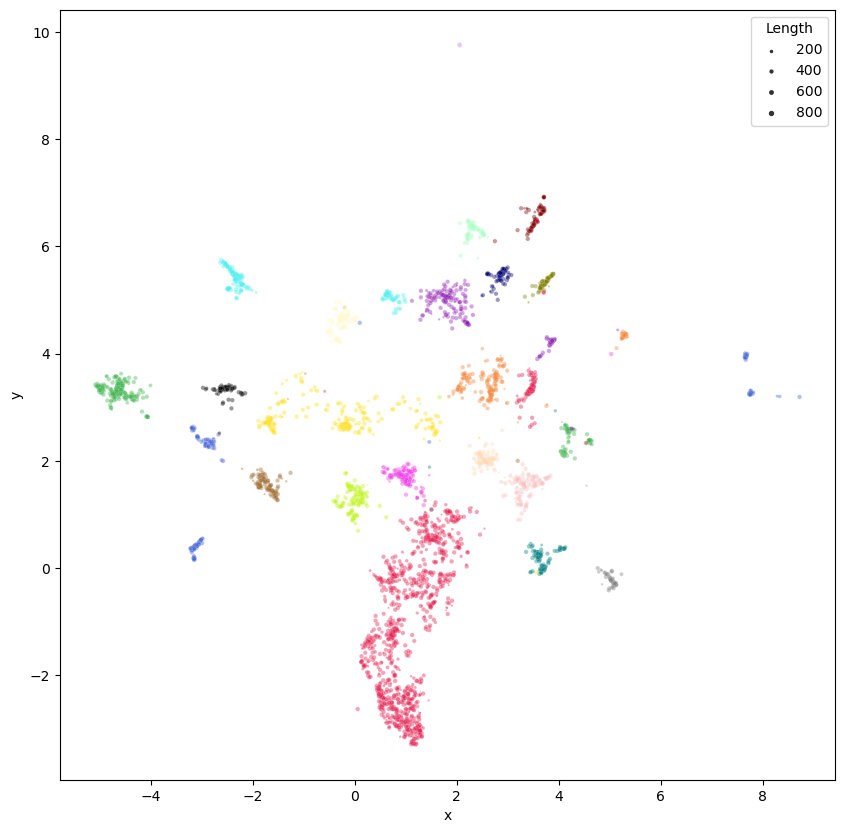

In [74]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()